# 1.Importing the libraries

In [1]:
pip install feature_engine

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

from feature_engine.datetime import DatetimeFeatures

from xgboost import XGBRegressor

import joblib

import matplotlib.pyplot as plt

## 2.display settings

In [4]:
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output = "default")

## 3 . Get the data

In [5]:
train_df = pd.read_csv("data/train.csv")

In [6]:
test_df = pd.read_csv("data/test.csv")

In [7]:
val_df = pd.read_csv("data/val.csv")

### 3.1 Split the data

In [8]:
def split_data(data):
    x = data.drop(columns = "price")
    y = data.price.copy()
    return(x,y)

In [9]:
x_train,y_train = split_data(train_df)

In [10]:
x_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-03-24,Kolkata,Banglore,21:10:00,08:10:00,660,1.0,In-flight meal not included
1,Spicejet,2019-03-03,Kolkata,Banglore,17:15:00,19:45:00,150,0.0,No Info
2,Indigo,2019-05-21,Mumbai,Hyderabad,09:10:00,10:40:00,90,0.0,No Info
3,Multiple Carriers,2019-05-15,Delhi,Cochin,13:00:00,01:30:00,750,1.0,No Info
4,Jet Airways,2019-06-03,Delhi,Cochin,19:15:00,19:00:00,1425,1.0,No Info
...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-05-01,Kolkata,Banglore,08:25:00,09:20:00,1495,1.0,No Info
636,Jet Airways,2019-06-24,Delhi,Cochin,19:45:00,04:25:00,520,1.0,In-flight meal not included
637,Multiple Carriers,2019-03-03,Delhi,Cochin,07:05:00,21:00:00,835,1.0,No Info
638,Spicejet,2019-03-09,Chennai,Kolkata,17:45:00,20:05:00,140,0.0,No Info


In [11]:
x_val,y_val = split_data(val_df)

In [12]:
x_test,y_test = split_data(test_df)

In [13]:
x_test.shape

(200, 9)

In [14]:
x_val.shape

(160, 9)

In [15]:
x_train.shape

(640, 9)

## 4. Data Preprocessing

In [16]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


In [18]:
dt_cols = ["date_of_journey", "dep_time", "arrival_time"]

num_cols = ["duration", "total_stops"]

cat_cols = [col for col in x_train.columns if (col not in dt_cols) and (col not in num_cols)]

In [19]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [20]:
num_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="median")),
	("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

In [21]:
doj_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format="mixed")),
	("scaler", StandardScaler())
])

time_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], format="mixed")),
	("scaler", StandardScaler())
])

In [22]:
preprocessor = ColumnTransformer(transformers =[
    ("num",num_transformer,num_cols),
    ("cat",cat_transformer,cat_cols),
    ("doj",doj_transformer,["date_of_journey"]),
    ("time",time_transformer,["arrival_time","dep_time"])
])

In [23]:
preprocessor.fit_transform(x_train)

array([[ 0.08214614,  0.24173208,  0.        , ..., -0.88810411,
         1.54842162, -0.71357964],
       [-0.9678832 , -1.21778237,  0.        , ...,  1.24639504,
         0.83264709, -0.44728753],
       [-1.09141606, -1.21778237,  0.        , ...,  0.94146659,
        -0.59890197, -0.71357964],
       ...,
       [ 0.44245032,  0.24173208,  0.        , ..., -1.49796101,
        -0.95678923, -0.97987175],
       [-0.98847201, -1.21778237,  0.        , ..., -1.19303256,
         0.83264709,  1.15046513],
       [-0.9781776 , -1.21778237,  0.        , ...,  0.02668124,
        -0.59890197, -1.24616386]])

## 5.Model selection

In [24]:
algorithms = {
	"Linear Regression": LinearRegression(),
	"Support Vector Machine": SVR(),
	"Random Forest": RandomForestRegressor(n_estimators=10),
	"XG Boost": XGBRegressor(n_estimators=10)
}
data = pd.concat([train_df, val_df], axis=0)

X_data, y_data = split_data(data)
print(X_data.shape, y_data.shape)

(800, 9) (800,)


In [25]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [26]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
	model = Pipeline(steps=[
		("pre", preprocessor),
		("alg", algorithm)
	])

	train_sizes, train_scores, test_scores = learning_curve(
		estimator=model,
		X=X_data,
		y=y_data,
		cv=3,
		scoring="r2",
		n_jobs=-1,
		random_state=42
	)
	
	mean_train_scores = np.mean(train_scores, axis=1)
	std_train_scores = np.std(train_scores, axis=1)
	train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

	mean_test_scores = np.mean(test_scores, axis=1)
	std_test_scores = np.std(test_scores, axis=1)
	test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

	fig, ax = plt.subplots(figsize=figsize)

	# training curve
	plot_curves(
		train_sizes,
		mean_train_scores,
		std_train_scores,
		f"Train ({train_score})",
		ax
	)

	# test curve
	plot_curves(
		train_sizes,
		mean_test_scores,
		std_test_scores,
		f"Test ({test_score})",
		ax
	)

	ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)

	ax.legend(loc="lower right")

	plt.show()

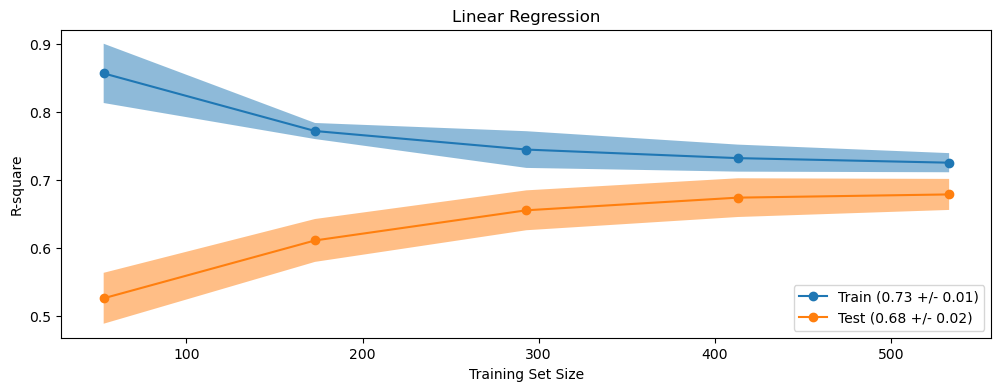

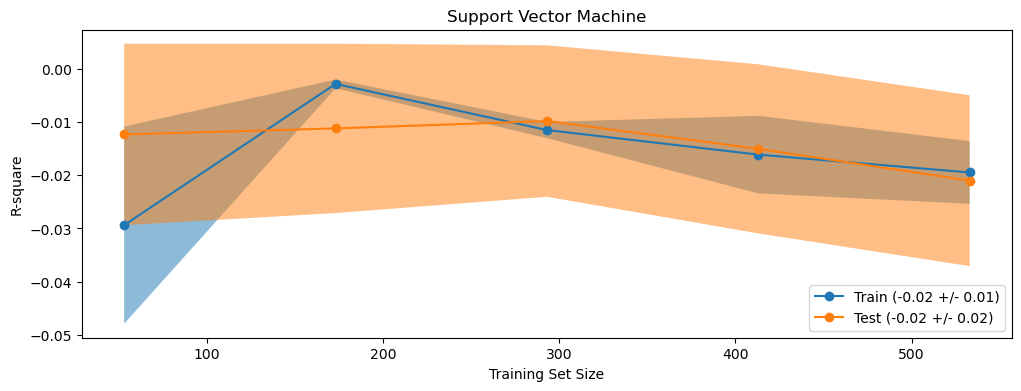

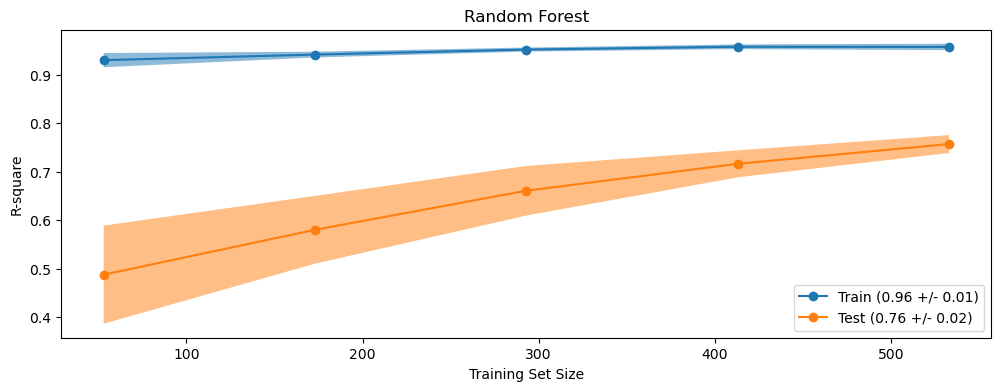

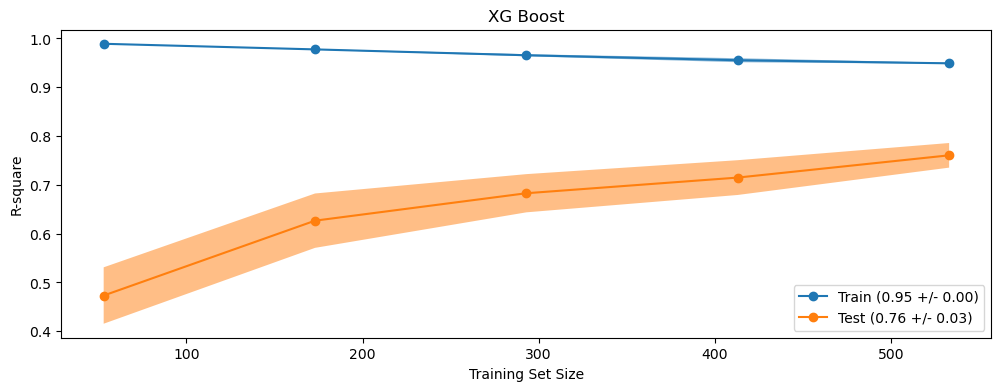

In [27]:
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)


## 6.Model training

In [28]:
model = Pipeline(steps=[
	("pre", preprocessor),
	("rf", RandomForestRegressor(n_estimators=10))
])
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['arrival_time',
                                                   'dep_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

## 7 . Model Evaluation

In [29]:
def evaluate_model(X, y):
	y_pred = model.predict(X)
	return r2_score(y, y_pred)
print(f"R2 score on Training data is = {evaluate_model(X_data, y_data)}")

R2 score on Training data is = 0.9591414256381591


In [30]:
print(f"R2 score on Test data is = {evaluate_model(x_test, y_test)}")

R2 score on Test data is = 0.810531648653505


## 8.Model Persistance

In [31]:
joblib.dump(model, "model.joblib")
['model.joblib']
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['arrival_time',
                                                   'dep_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [32]:
y_pred = saved_model.predict(x_test)

r2_score(y_test, y_pred)

0.810531648653505